<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Installazione librerie e setup ambiente

In [2]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [42]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio


In [4]:
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))
print("Userai:", device)

GPU disponibile: []


NameError: name 'device' is not defined

Collegamento al drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [6]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [213]:
%ls /content/drive/MyDrive/HumanData/ESC-10/


chainsaw/    crackling_fire/  dog/         rain/     sea_waves/
clock_tick/  crying_baby/     helicopter/  rooster/  sneezing/


## Processare tutti i file audio di ESC10

In [234]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100  # non fare downsampling
DURATION = 5.0       # lunghezza standard (secondi)

decido di non rimuovere il silenzio

In [235]:
def load_audio_file(file_path, sr=44100, duration=5.0):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    y = librosa.util.normalize(y)           # normalizzazione RMS
    if len(y) < int(sr * duration):
        padding = int(sr * duration) - len(y)
        y = np.pad(y, (0, padding))         # padding se troppo corto
    return y

In [250]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


In [251]:
X_audio = np.array(X_audio)
y_labels = np.array(y_labels)

print("Shape X:", X_audio.shape)
print("Shape y:", y_labels.shape)

Shape X: (400, 220500)
Shape y: (400,)


In [252]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.3, random_state=42, stratify=y_labels)

# Poi dividi temp in val e test (50/50 => 15% ciascuno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 280, Val: 60, Test: 60


## NAA

tolgo il silenzio? su esc10 si su esc50 no ?
metto noise injection?
noise = np.random.normal(0, 0.005, y.shape)
  y_noisy = y + noise
  augmented.append(y_noisy)

In [253]:
def naa(y, sr):
  augmented = []
  augmented.append(y)
  #PPS
  augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2))
  #NPS
  augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2))
  #Slow Time Stretching
  augmented.append(librosa.effects.time_stretch(y, rate=0.7))
  #Fast Time Streatching
  augmented.append(librosa.effects.time_stretch(y, rate=1.2))
  return augmented

In [254]:
X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train)), desc="NAA"):
    original_audio = X_train[i]
    label = y_train[i]

    # Applica la tua funzione naa → restituisce 5 versioni (incluso l'originale)
    augmented_audios = naa(original_audio, sr=SAMPLE_RATE)

    # Aggiungi tutte le versioni alla lista finale
    X_train_aug.extend(augmented_audios)
    y_train_aug.extend([label] * len(augmented_audios))


NAA: 100%|██████████| 280/280 [02:22<00:00,  1.97it/s]


## Converti in log-Mel

In [255]:
def preprocess_audio(y, sr=44100, n_mels=64, n_fft=1024, hop_length=512):
  #Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel


In [256]:
def batch_logmel(X, sr=44100):
    mel_list = []
    for x in tqdm(X, desc="Log-Mel"):
        mel = preprocess_audio(x, sr=sr)
        mel_list.append(mel)
    return mel_list


In [257]:
X_train_mel = batch_logmel(X_train_aug)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)

Log-Mel: 100%|██████████| 60/60 [00:00<00:00, 81.25it/s]


In [258]:
print("Train set:", len(X_train_mel))
print("Val set:", len(X_val_mel))
print("Test set:", len(X_test_mel))

print("Shape primo sample train:", X_train_mel[0].shape)

Train set: 1400
Val set: 60
Test set: 60
Shape primo sample train: (64, 431)


visualizzo logmel spect

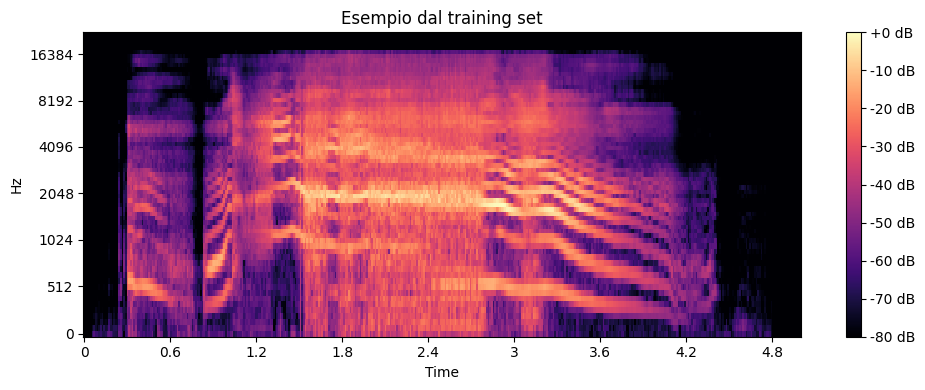

Class:  3


In [260]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualizza un esempio a caso dal training set
show_mel(X_train_mel[0], title="Esempio dal training set")
print("Class: ", y_train_aug[0])


In [261]:
all_vals = np.concatenate([mel.flatten() for mel in X_train_mel])
print("Min:", np.min(all_vals))
print("Max:", np.max(all_vals))

Min: -80.0
Max: 0.0


Padding

In [262]:
max_len = max([mel.shape[1] for mel in X_train_mel])
def pad_mel(mel, max_len):
    if mel.shape[1] < max_len:
        pad_width = max_len - mel.shape[1]
        return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=-80)
    else:
        return mel[:, :max_len]
X_train_mel = [pad_mel(mel, max_len) for mel in X_train_mel]
X_val_mel = [pad_mel(mel, max_len) for mel in X_val_mel]
X_test_mel = [pad_mel(mel, max_len) for mel in X_test_mel]


## DATA AUG TAA

In [263]:
taa_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    brightness_range=[0.5, 1.5],
    shear_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [264]:
X_train_mel_np = np.array(X_train_mel)
X_val_mel_np = np.array(X_val_mel)
X_test_mel_np = np.array(X_test_mel)

if len(X_train_mel_np.shape) == 3:
    X_train_mel_np = X_train_mel_np[..., np.newaxis]  # (N, 64, 431, 1)

y_train_np = np.array(y_train_aug)  # Etichette corrispondenti

Normalizzazione

In [265]:
X_train_mel_np = (X_train_mel_np + 80.0) / 80.0
X_val_mel_np = (X_val_mel_np + 80.0) / 80.0
X_test_mel_np = (X_test_mel_np + 80.0) / 80.0

Converto in tensori

In [266]:
X_train = torch.from_numpy(X_train_mel_np).float()
y_train = torch.from_numpy(y_train_np).float()
X_val = torch.from_numpy(X_val_mel_np).float()
y_val = torch.from_numpy(np.array(y_val)).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_test = torch.from_numpy(np.array(y_test)).float()

In [267]:
print("Shape X_train:", X_train.shape)
print("Tipo dati:", X_train.dtype)
print("Valori min/max:", torch.min(X_train), torch.max(X_train))


Shape X_train: torch.Size([1400, 64, 616, 1])
Tipo dati: torch.float32
Valori min/max: tensor(0.) tensor(1.)


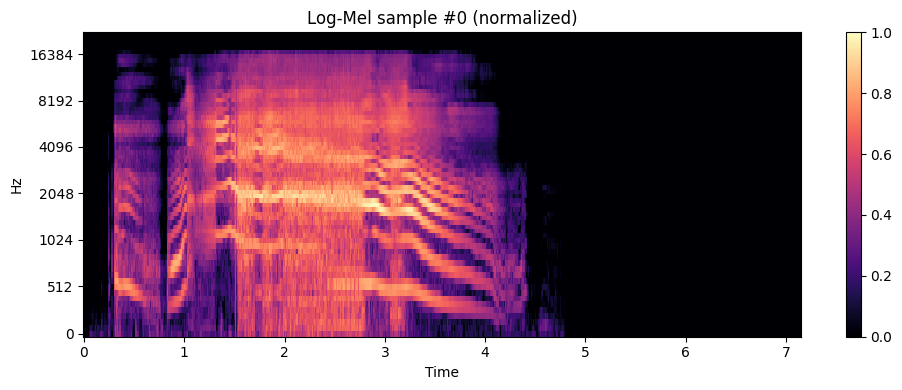

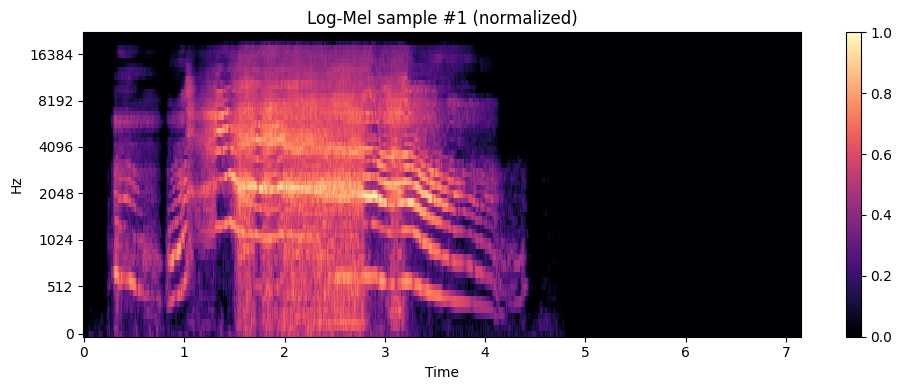

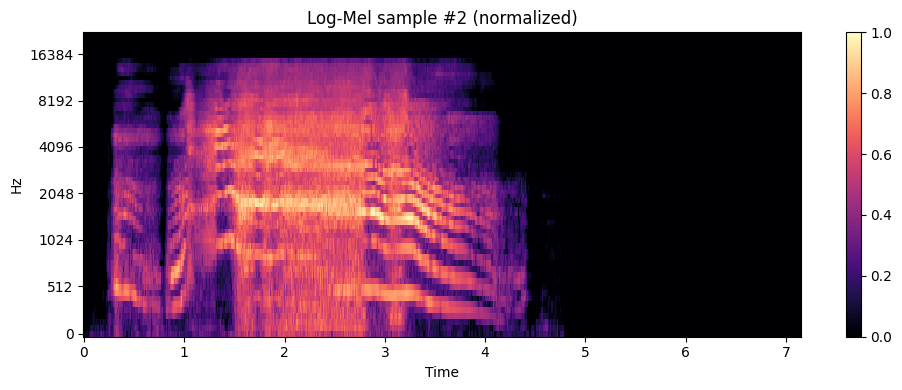

In [268]:
def show_mel_sample(index):
    mel = X_train[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=sample_rate, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar()  # non usare '%+2.0f dB' perché ora i valori sono [0, 1]
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()

for i in range(3):
    show_mel_sample(i)

In [269]:
print("y_train shape:", y_train.shape)
print("Etichette uniche:", np.unique(y_train))

# Stampa etichetta di un esempio
for i in range(3):
    print(f"Esempio {i}: label = {y_train[i]}")


y_train shape: torch.Size([1400])
Etichette uniche: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Esempio 0: label = 3.0
Esempio 1: label = 3.0
Esempio 2: label = 3.0


# Spike Encoding


## Rate Encoding

Si tratta di un metodo classico e semplice: l'informazione viene codificata nella frequenza di sparo (numero di spike per unità di tempo). Stimolo più alto → frequenza più alta. Non è importante l'esatta tempistica degli spike, ma solo il loro numero.

Each normalized input feature $X_{i,j}$ is used as the probability a spike occurs at any given time step.

Bernoulli trial: $R_{i,j} \sim B(n, p)$

The probability a spike occurs is:
$P(R_{i,j} = 1) = X_{i,j} = 1 - P(R_{i,j} = 0)$

We show now the distribution of values of a single mel plot

Min: 0.0000
Max: 1.0000
Mean: 0.2424
Std: 0.2764


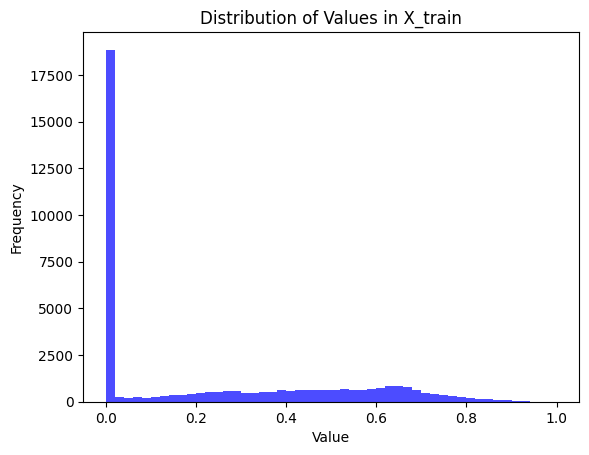

In [29]:
# simulation time steps
X_train_rate_batch = torch.squeeze(X_train)[0:1]

# Flatten to 1D for easy stats and histogram
tensor_flat = X_train_rate_batch.flatten()

# Print basic stats
print(f"Min: {tensor_flat.min().item():.4f}")
print(f"Max: {tensor_flat.max().item():.4f}")
print(f"Mean: {tensor_flat.mean().item():.4f}")
print(f"Std: {tensor_flat.std().item():.4f}")

# Plot histogram
plt.hist(tensor_flat.cpu().numpy(), bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Values in X_train")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

Now we generate the spike ratings over a single mel plot

In [38]:
simulation_steps = 50
rate_spike_train = spikegen.rate(data=X_train_rate_batch, num_steps=simulation_steps, gain=1)
print(rate_spike_train.shape)

torch.Size([50, 1, 64, 616])


**simulation_steps** is needed because data is converted into spikes that evolve over 50 time steps. Each step simulates activity in an SNN at that particular moment in time

Now we visualize the spike_train

torch.Size([50, 39424])


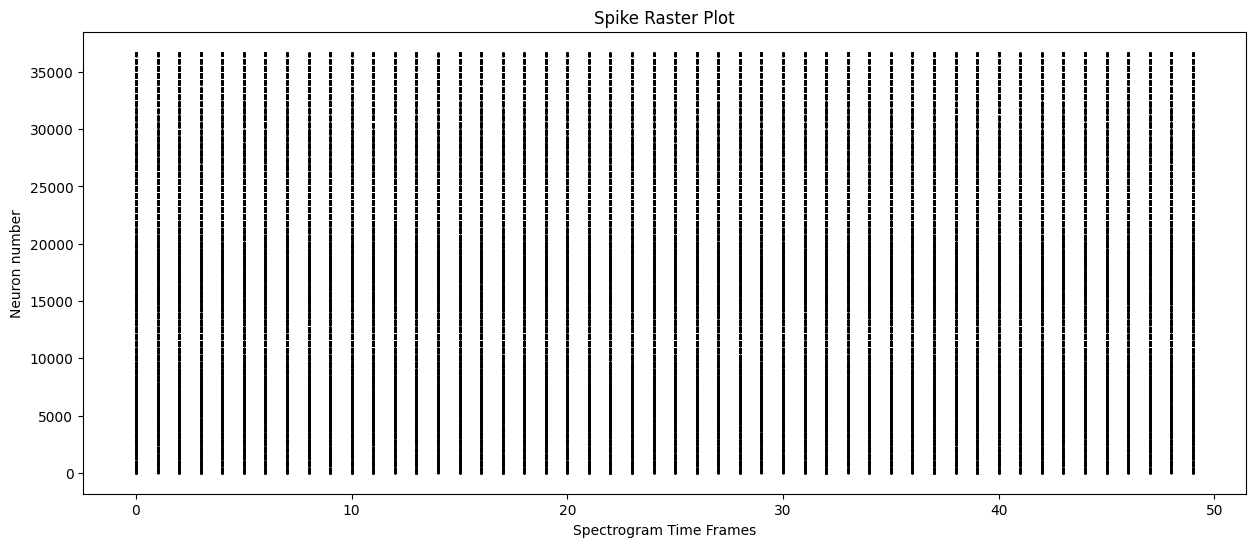

In [270]:
spike_sample = rate_spike_train[:, 0, :, :].reshape((simulation_steps, -1))
print(spike_sample.reshape((simulation_steps, -1)).shape)
#spike_raster = torch.sum(spike_sample, dim=1).reshape((simulation_steps, -1))  # shape: (50, 616)

fig, ax = plt.subplots(figsize=(15, 6))
splt.raster(spike_sample, ax, s=0.5, c="black")
ax.set_xlabel("Spectrogram Time Frames")
ax.set_ylabel("Neuron number")
ax.set_title("Spike Raster Plot")
plt.show()

The number of neurons is decided based on this multiplication:

n_mels * time_bins $\rightarrow 64 * 616 = 39424$  

Now we visualize how a single neuron out of 39424 behaves

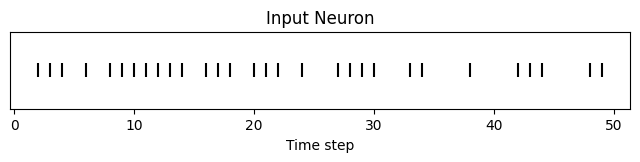

In [271]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_sample.reshape((simulation_steps, -1))[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

## Latency (or Temporal) Coding

## Delta Modulation

## Threshold Adaptive Encoding

Unlike **rate encoding**, where the value directly determines spike probability, Threshold Adaptive Encoding works by:

Setting a dynamic threshold for each input feature
Generating spikes when the input signal crosses this threshold
Adapting the threshold after each spike according to the local signal properties

This encoding method is biologically inspired, as it better mimics how neurons in the brain respond to varying stimulus intensities.


We create now the ThresholdAdaptiveEncoder class that will contain all the useful methods.

In [204]:
class ThresholdAdaptiveEncoder:
    """
    Threshold Adaptive Encoder for converting analog signals to spike trains.

    This encoder generates spikes when the input crosses a dynamic threshold,
    which is then increased after each spike and gradually decays over time.
    """

    def __init__(self, threshold_init=0.1, threshold_increase=0.2, threshold_decay=0.02):
        """
        Initialize the encoder parameters.

        Args:
            threshold_init: Initial threshold value
            threshold_increase: Amount to increase threshold after a spike
            threshold_decay: Rate at which threshold decays over time
        """
        self.threshold_init = threshold_init
        self.threshold_increase = threshold_increase
        self.threshold_decay = threshold_decay

    def encode(self, data, num_steps):
        """
        Encode analog data into spike trains using adaptive threshold.

        Args:
            data: Input tensor of shape (batch_size, channels, height, width)
            num_steps: Number of time steps for the spike train

        Returns:
            Spike tensor of shape (num_steps, batch_size, height, width, channels)
        """
        batch_size, height, width, channels = data.shape

        spikes = torch.zeros((num_steps, batch_size, height, width, channels),
                            device=data.device)

        thresholds = torch.ones_like(data) * self.threshold_init

        for t in range(num_steps):
            current_spikes = (data > thresholds).float() # produces binary tensor
            spikes[t] = current_spikes

            # update thresholds
            thresholds = thresholds + (current_spikes * self.threshold_increase)

            # Decay all thresholds
            thresholds = thresholds - self.threshold_decay
            thresholds = torch.clamp(thresholds, min=self.threshold_init)

        return spikes

Now we encode the just the first batch of X_train

In [206]:
thresholdEncoder = ThresholdAdaptiveEncoder(threshold_init=0.001, threshold_increase=0.1, threshold_decay=0.02)
X_train_threshold_batch = X_train[0:1]
threshold_encoded_spikes = thresholdEncoder.encode(data=X_train_threshold_batch,
                                                    num_steps=50)

print(threshold_encoded_spikes.shape)

torch.Size([50, 1, 64, 616, 1])


In [183]:
for i in range(threshold_encoded_spikes.shape[0]):
    sample = threshold_encoded_spikes[i].squeeze(0).squeeze(-1)  # shape [64, 616]

    num_ones = (sample == 1).sum().item()
    num_zeros = (sample == 0).sum().item()

    print(f"Iter {i+1}: Number of 1s = {num_ones}, Number of 0s = {num_zeros}")

Iter 1: Number of 1s = 20791, Number of 0s = 18633
Iter 2: Number of 1s = 19872, Number of 0s = 19552
Iter 3: Number of 1s = 19019, Number of 0s = 20405
Iter 4: Number of 1s = 17507, Number of 0s = 21917
Iter 5: Number of 1s = 15891, Number of 0s = 23533
Iter 6: Number of 1s = 14113, Number of 0s = 25311
Iter 7: Number of 1s = 12037, Number of 0s = 27387
Iter 8: Number of 1s = 10061, Number of 0s = 29363
Iter 9: Number of 1s = 7669, Number of 0s = 31755
Iter 10: Number of 1s = 5743, Number of 0s = 33681
Iter 11: Number of 1s = 4607, Number of 0s = 34817
Iter 12: Number of 1s = 4137, Number of 0s = 35287
Iter 13: Number of 1s = 4163, Number of 0s = 35261
Iter 14: Number of 1s = 4229, Number of 0s = 35195
Iter 15: Number of 1s = 4258, Number of 0s = 35166
Iter 16: Number of 1s = 4100, Number of 0s = 35324
Iter 17: Number of 1s = 4049, Number of 0s = 35375
Iter 18: Number of 1s = 4155, Number of 0s = 35269
Iter 19: Number of 1s = 4229, Number of 0s = 35195
Iter 20: Number of 1s = 4258, Nu

In [211]:
def visualize_threshold_encoding(data, encoder, num_steps=50, neuron_idx=(32, 200, 0)):
    """
    Visualize the threshold adaptive encoding for a single neuron.

    Args:
        data: Input tensor (single sample)
        encoder: ThresholdAdaptiveEncoder instance
        num_steps: Number of time steps to simulate
        neuron_idx: (row, col, channel) indices of neuron to visualize
    """
    input_value = data[0, neuron_idx[0], neuron_idx[1], neuron_idx[2]].item()

    threshold_history = [encoder.threshold_init]
    spike_history = []

    threshold = encoder.threshold_init

    # Simulate encoding for the specified neuron
    for t in range(num_steps):
        spike = 1.0 if input_value > threshold else 0.0
        spike_history.append(spike)

        if spike > 0:
            threshold += encoder.threshold_increase
        threshold -= encoder.threshold_decay
        threshold = max(threshold, encoder.threshold_init)

        threshold_history.append(threshold)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot threshold over time
    time_steps = range(num_steps + 1)
    ax.plot(time_steps, threshold_history, 'r-', label='Threshold')

    ax.axhline(y=input_value, color='blue', linestyle='-', label='Input Value')

    spike_times = [t for t, s in enumerate(spike_history) if s > 0]
    for t in spike_times:
        ax.axvline(x=t, color='green', alpha=0.5)

    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.set_title(f'Threshold Adaptive Encoding for Neuron {neuron_idx}')
    ax.legend()

    spike_y = [input_value] * len(spike_times)
    ax.scatter(spike_times, spike_y, color='green', s=100, marker='|', label='Spikes')

    plt.tight_layout()
    plt.show()

    # Also display the spike train
    fig, ax = plt.subplots(figsize=(10, 2))
    spike_train = torch.tensor([spike_history])
    splt.raster(spike_train.T, ax, s=100, c="black", marker="|")
    ax.set_title(f"Spike Train for Neuron {neuron_idx}")
    ax.set_xlabel("Time step")
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()

torch.Size([1, 64, 616, 1])


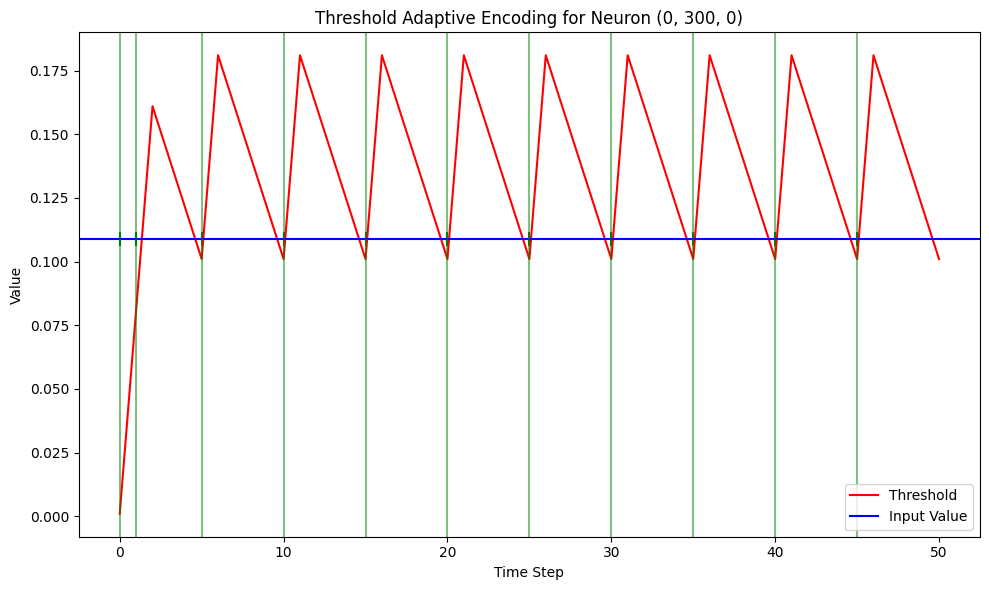

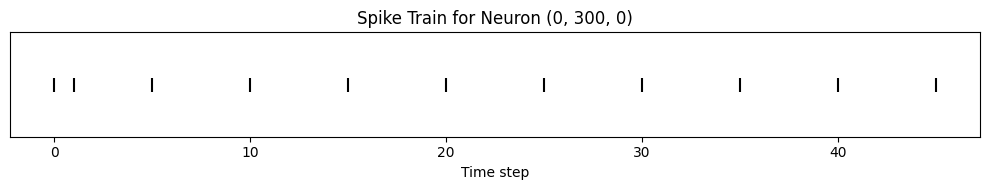

In [212]:
print(X_train_threshold_batch.shape)
visualize_threshold_encoding(X_train_threshold_batch, thresholdEncoder, num_steps=50, neuron_idx=(0, 300, 0))

## Moving Window

## Step Forward